In [1]:
import sys
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
# initialisation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from lib import ressources as res
racine = os.path.abspath(os.path.realpath(res.dir_root))

dataset_test = res.dir_dataset_test
print(dataset_test)

C:\Users\NOEL\dev\python\dataset\plant-dataset\test


In [3]:
### Définition d'une fonction de perte : Coefficient de Dice
def LossDice(y_true, y_pred):
  numerateur  =tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur=tf.reduce_sum(y_true+y_pred, axis=(1, 2))
  dice=2*numerateur/(denominateur+1E-4)
  return 1-dice

In [4]:
# le modèle entraîné est récupéré
def load_saved_unet():
    
    model = tf.keras.models.load_model('data/unet_model.h5')
    model.summary()
    return model

unet = load_saved_unet()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [5]:
# chargement des images et masques après transformations


def load_image(filepath,resize=(256,256)):
    # l'information brute est chargée en mémoire
    im = tf.io.read_file(filepath)
    # l'information est décodée pour être transformée en un tensorflow RGB (3 channels)
    im = tf.io.decode_jpeg(im, channels=3)
    # l'image redimensionnée est retournée
    return tf.image.resize(im, size=resize)
  
def load_mask(filepath,resize=(256,256)):
    # l'information brute est chargée en mémoire
    im = tf.io.read_file(filepath)
    # dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
    im = tf.io.decode_jpeg(im, channels=1)
    # retourne l'image redimensionnée
    return tf.image.resize(im, size=resize)

In [6]:
# les prédictions sont réalisées
def predictions():
    images = []
    masques = []

    # chemin des images de test
    path_images=[]
    for path in glob.glob(dataset_test):
        path_images += glob.glob(path+'/'+'**')

    # pour chaque image
    for path_image in path_images:
        # l'image est lue
        im = cv2.imread(path_image)
        # l'image est ajoutée
        images.append(im)

        # l'image est chargée avec transformations
        tmp_im = load_image(path_image)
        # l'image est redimentionnée
        tmp_im = tf.reshape(tmp_im,(1, 256, 256, 3))
        # prédiction du cnn qui renvoi le masque de l'image
        masque = unet.predict(tmp_im)
        # le masque retourné par le cnn est ajouté
        masques.append(masque)

        # suppression des variables
        del im
        del tmp_im
        del masque

    # les images et les masques correspondants sont retournés
    return images, masques 


In [7]:
# les images issues de la prédiction du cnn sont ajoutées
def affiche_prediction(im, pred):

    # l'image d'origine est affichée
    plt.figure(figsize=(8, 4))
    plt.subplot(141)
    plt.imshow(im)
    plt.title("Image d'origine")
    plt.axis('off')

    # masque de la photo d'origine
    plt.subplot(142)
    plt.imshow(pred.reshape(256, 256),cmap='gray')
    plt.title("Masque")
    plt.axis('off')

    
    # superposition du masque et de l'image
    plt.subplot(143)
    plt.imshow(im)
    plt.imshow(pred.reshape(256,256), alpha=0.5)
    plt.title("Superposition")
    plt.axis('off');

    # la segmentation est réalisée en multipliant le masque et l'image à segmenter
    seg=(im * pred.reshape(256, 256, 1)).astype(int)
    plt.subplot(144)
    plt.imshow(seg)
    plt.title("Segmentation")
    plt.axis('off');
    # cv2.imwrite('plante.png', seg)

    # suppression des variables
    del im 
    del pred
    del seg



In [8]:
# pour chaque masque, les bounding box sont calculés et affichés avec l'image correspondante
def bounding_box(image, mask):

    bounding_box_color=(255, 0, 0)
    countour_surface=10000

    # les dimensions inutiles sont supprimées
    mask = mask.squeeze()

    # le masque étant noir et blanc, il est redimentionné à 3 dimensions
    mask = cv2.merge([mask,mask,mask])

    # la normalisation est supprimée
    mask = mask * 256

    # les valeurs sont mises au format int8
    mask = mask.astype(np.uint8)

    # le masque au format cv2 est transformé en gris
    img = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # les pixels sont mis à 0 ou 1 suivant leur valeur par rpport au seuil choisi
    ret, thresh = cv2.threshold(src=img, thresh=127, maxval=255, type=0)

    # les contours trouvés dans l'image sont détectés
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # pour chaque contour trouvé
    for contour in contours:

        # pour chaque contour donc la surface est suffisant pour être pris en compte
        if cv2.contourArea(contour) > countour_surface:
            # print('Surface du contour -> ', cv2.contourArea(contour))
            x,y,w,h = cv2.boundingRect(contour)

            # l'image et le bounding box sont dessinés
            plt.figure(figsize=(5, 3))
            image = cv2.rectangle(img=image, pt1=(x, y), pt2=(x+w, y+h), color=bounding_box_color, thickness=2)
            plt.axis('off')
            plt.imshow(image)

    cv2.destroyAllWindows()

# bounding_box(images[14], masques[14])

<ipython-input-7-dcfaf41535e8>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 4))


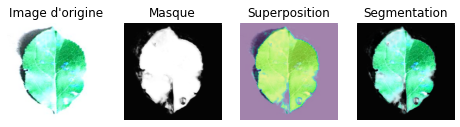

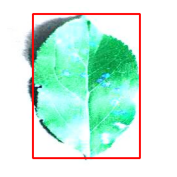

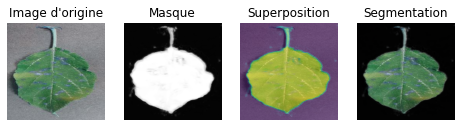

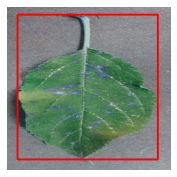

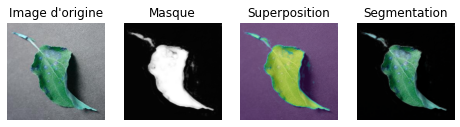

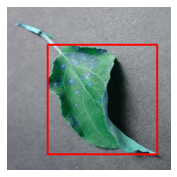

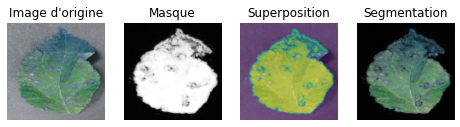

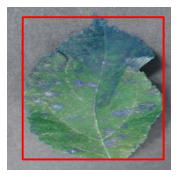

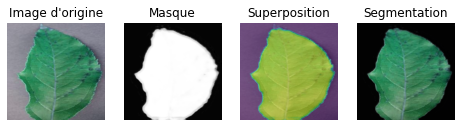

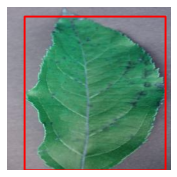

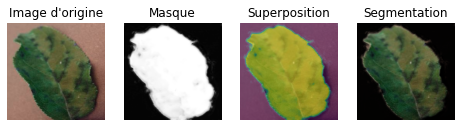

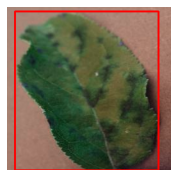

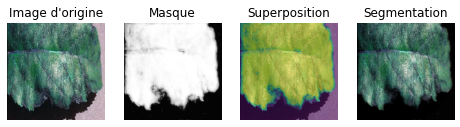

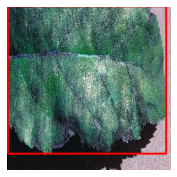

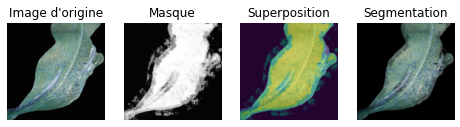

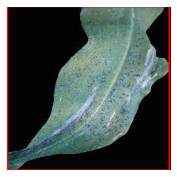

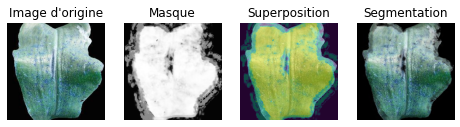

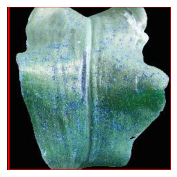

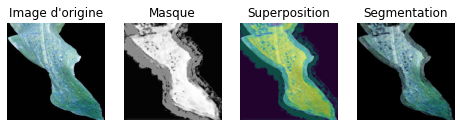

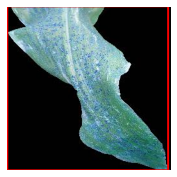

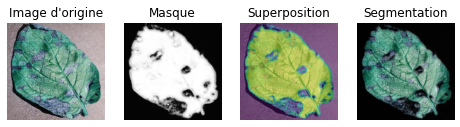

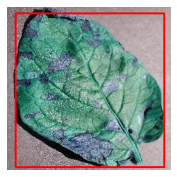

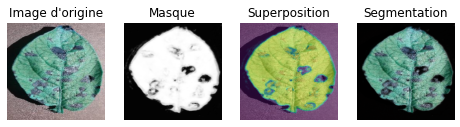

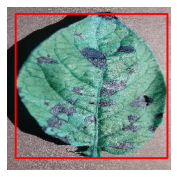

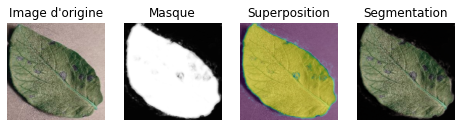

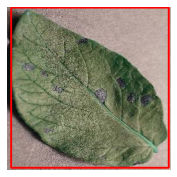

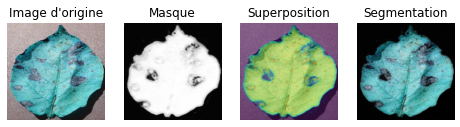

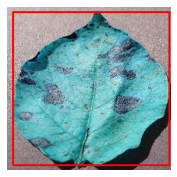

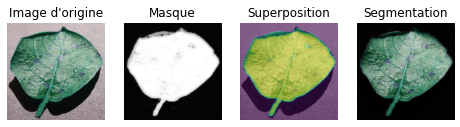

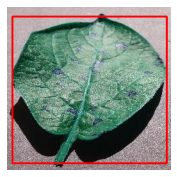

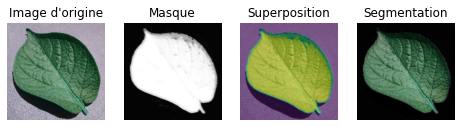

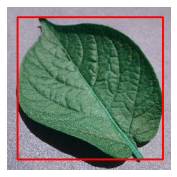

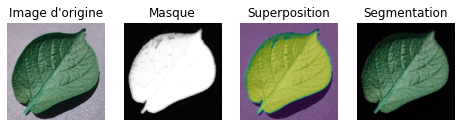

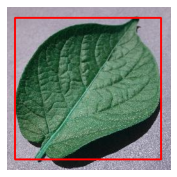

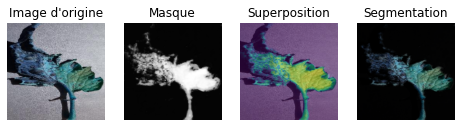

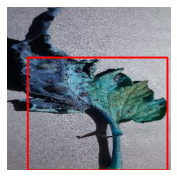

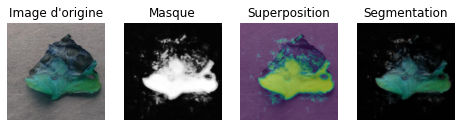

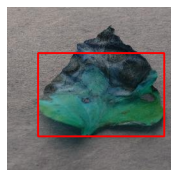

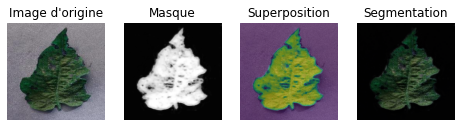

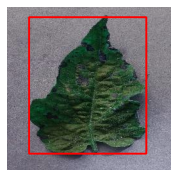

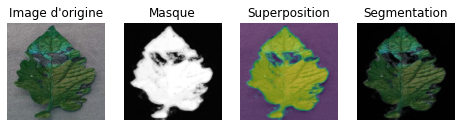

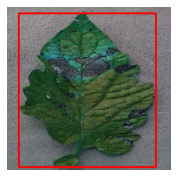

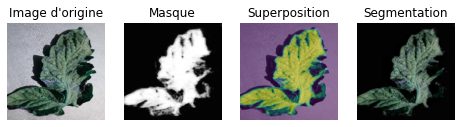

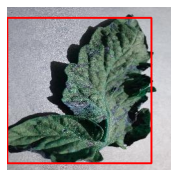

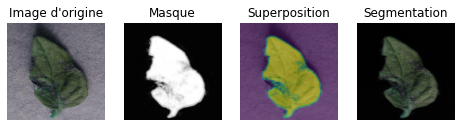

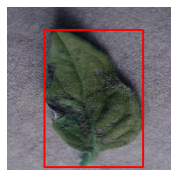

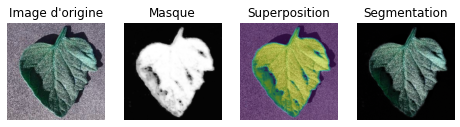

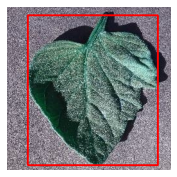

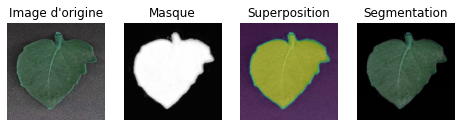

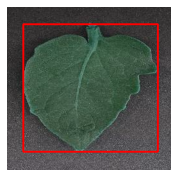

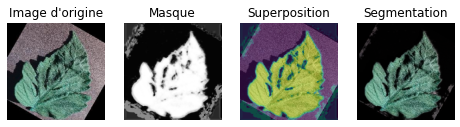

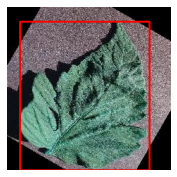

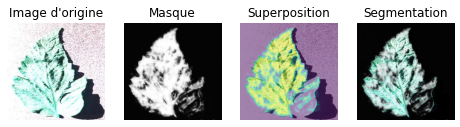

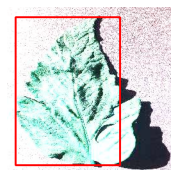

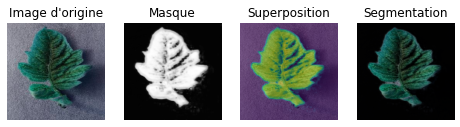

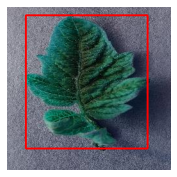

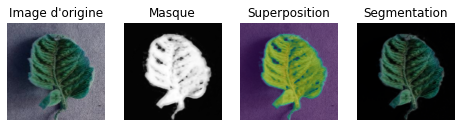

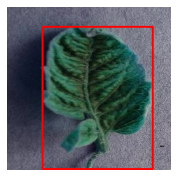

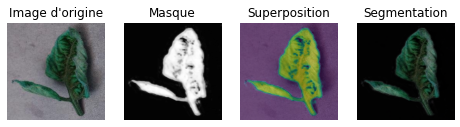

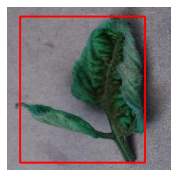

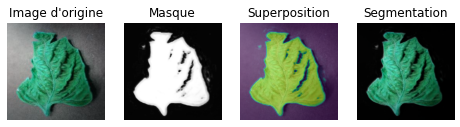

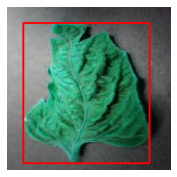

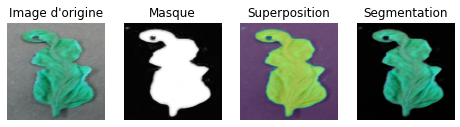

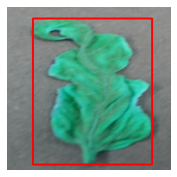

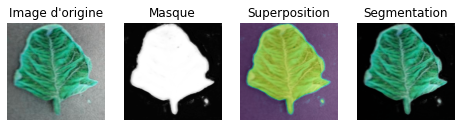

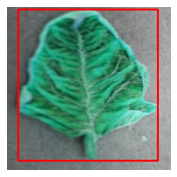

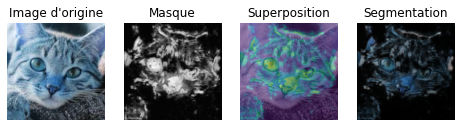

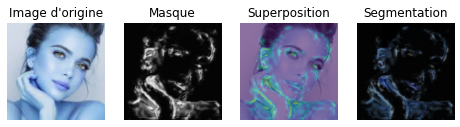

In [9]:
# prédictions du cnn
images, masques = predictions()

# pour chaque prédiction
for i in range(0, len(images)):
    # les images issues de la prédiction sont affichées
    affiche_prediction(images[i], masques[i])
    # les bounding box calculés à partir des masques sont affichés
    bounding_box(images[i], masques[i])
